In [1]:
import tensorflow as tf
import zipfile,os
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

In [2]:
!wget --no-check-certificate https://insightdemo.000webhostapp.com/chestdata_2.zip

--2021-12-02 06:57:19--  https://insightdemo.000webhostapp.com/chestdata_2.zip
Resolving insightdemo.000webhostapp.com (insightdemo.000webhostapp.com)... 145.14.144.34, 2a02:4780:dead:c893::1
Connecting to insightdemo.000webhostapp.com (insightdemo.000webhostapp.com)|145.14.144.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116909787 (111M) [application/zip]
Saving to: ‘chestdata_2.zip’

chestdata_2.zip     100%[===================>] 111.49M   108MB/s    in 1.0s    

2021-12-02 06:57:20 (108 MB/s) - ‘chestdata_2.zip’ saved [116909787/116909787]



In [3]:
local_zip = '/content/chestdata_2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
base_dir = '/tmp/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [5]:
!pip install split_folders
import splitfolders

In [6]:
splitfolders.ratio('/tmp/dataset', '/tmp/process/data', seed=1, ratio=(.6, .4))

Copying files: 3000 files [00:00, 4534.61 files/s]


In [7]:
base_dir = '/tmp/process/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
os.listdir('/tmp/process/data/train')
os.listdir('/tmp/process/data/val')

['pneunomia', 'covid', 'normal']

In [8]:
#Train Set
train_normal_dir = os.path.join(train_dir, 'normal')
train_pneunomia_dir = os.path.join(train_dir, 'pneunomia')
train_covid_dir = os.path.join(train_dir, 'covid')

In [9]:
#Validation Set
validation_normal_dir = os.path.join(validation_dir, 'normal')
validation_pneunomia_dir = os.path.join(validation_dir, 'pneunomia')
validation_covid_dir = os.path.join(validation_dir, 'covid')

In [10]:
train_datagen = ImageDataGenerator(
  rescale=1./255, 
  shear_range=0.2, 
  zoom_range=0.2, 
  horizontal_flip=True) 

In [11]:
test_datagen = ImageDataGenerator(
  rescale=1./255,
  shear_range=0.2, 
  zoom_range=0.2,
  horizontal_flip=True)

In [12]:
train_generator = train_datagen.flow_from_directory(
  train_dir, #direktori data latihnya
  target_size=(150, 150), #Mengubah Resolusi 
  batch_size=64, 
  color_mode='rgb', #Menggunakan Rgb
  class_mode='categorical', 
  shuffle = True, 
  seed=42)

validation_generator = test_datagen.flow_from_directory(
  validation_dir, #direktori data validasii
  target_size=(150, 150),
  batch_size=64,
  color_mode='rgb',
  class_mode='categorical',
  shuffle = True,
  seed=42)

Found 1800 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [13]:
sample_train_images, _ = next(train_generator)
sample_val_images, _ = next(validation_generator)

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

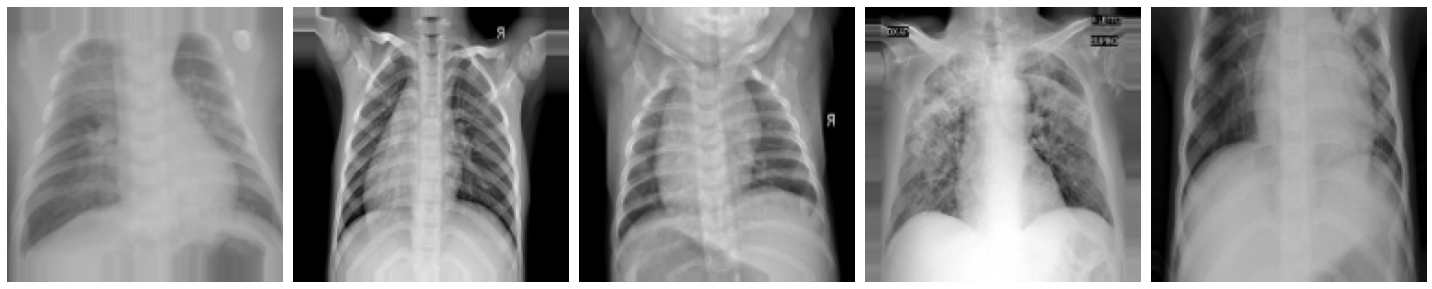

In [15]:
plotImages(sample_train_images[:6])

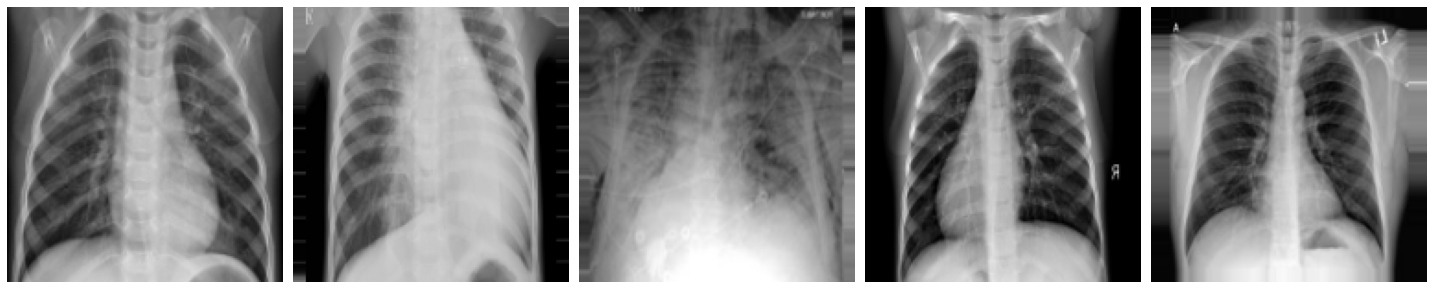

In [16]:
plotImages(sample_val_images[:6])

In [17]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape= (150,150,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3), activation= 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      #tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
      #tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3), activation= 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation= 'relu'),
      tf.keras.layers.Dense(3, activation= 'softmax')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [19]:
model.compile(optimizer = 'Adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [20]:
#train = model.fit(train_generator, 
#          steps_per_epoch=20, 
#          epochs=20, 
#          validation_data=validation_generator,
#          validation_steps=5,
#          verbose=1)

import math

batch_size=64
train_size=1800
validation_size=1200

#menghitung nilai step per epoch dan val step
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(train_size)
val_steps = compute_steps_per_epoch(validation_size)

base_model = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    validation_data=validation_generator,
    verbose=1)

Epoch 1/20
29/29 [==============================] - 61s 2s/step - loss: 1.0671 - accuracy: 0.4717 - val_loss: 0.6996 - val_accuracy: 0.6558
Epoch 2/20
29/29 [==============================] - 62s 2s/step - loss: 0.7874 - accuracy: 0.6617 - val_loss: 0.5881 - val_accuracy: 0.7675
Epoch 3/20
29/29 [==============================] - 62s 2s/step - loss: 0.5707 - accuracy: 0.7850 - val_loss: 0.4624 - val_accuracy: 0.8042
Epoch 4/20
29/29 [==============================] - 61s 2s/step - loss: 0.4955 - accuracy: 0.7967 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 5/20
29/29 [==============================] - 61s 2s/step - loss: 0.4726 - accuracy: 0.8056 - val_loss: 0.3752 - val_accuracy: 0.8608
Epoch 6/20
29/29 [==============================] - 60s 2s/step - loss: 0.4412 - accuracy: 0.8361 - val_loss: 0.4703 - val_accuracy: 0.8000
Epoch 7/20
29/29 [==============================] - 60s 2s/step - loss: 0.4367 - accuracy: 0.8239 - val_loss: 0.3649 - val_accuracy: 0.8725
Epoch 8/20
29/29 [==

In [21]:
score = model.evaluate(train_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

29/29 [==============================] - 22s 765ms/step - loss: 0.2442 - accuracy: 0.9194
Loss: 0.2442
Accuracy: 0.9194


In [22]:
score = model.evaluate(validation_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

19/19 [==============================] - 15s 776ms/step - loss: 0.2350 - accuracy: 0.9267
Loss: 0.2350
Accuracy: 0.9267


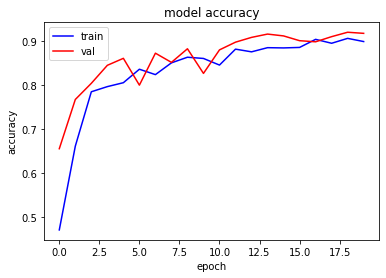

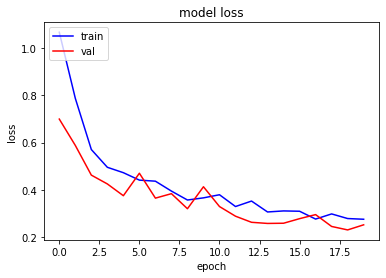

In [23]:
acc = base_model.history['accuracy']
val_acc = base_model.history['val_accuracy']
loss = base_model.history['loss']
val_loss = base_model.history['val_loss']
plt.plot(acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

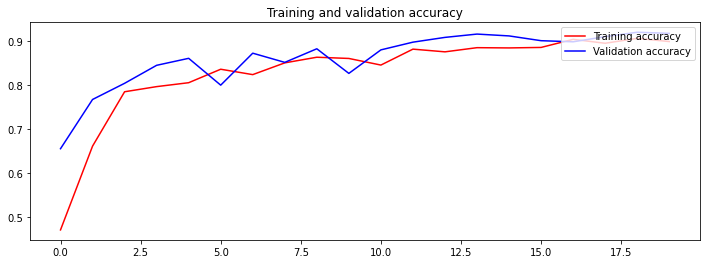

<Figure size 432x288 with 0 Axes>

In [24]:
acc2 = base_model.history['accuracy']
val_acc2 = base_model.history['val_accuracy']
loss = base_model.history['loss']
val_loss = base_model.history['val_loss']

epochs = range(len(acc2))

plt.figure(figsize=(12, 4))
plt.plot(epochs, acc2, 'r', label='Training accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='upper right')
plt.figure()


plt.show()

In [25]:
Y_pred = model.predict(validation_generator, 64+1)
y_pred = np.argmax(Y_pred, axis=1)

In [26]:
print('Classification Report')
target_names = ['normal', 'pneunomia', 'covid']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      normal       0.36      0.39      0.38       400
   pneunomia       0.32      0.33      0.32       400
       covid       0.36      0.33      0.35       400

    accuracy                           0.35      1200
   macro avg       0.35      0.35      0.35      1200
weighted avg       0.35      0.35      0.35      1200



In [27]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
confusion_array = sklearn.metrics.confusion_matrix(validation_generator.classes, y_pred)

print('True Negative = ', confusion_array[0,0])
print('False Negative = ', confusion_array[1,0])
print('True Positive = ', confusion_array[1,1])
print('False Positive = ', confusion_array[0,1])

Confusion Matrix
[[156 133 111]
 [149 130 121]
 [124 143 133]]
True Negative =  156
False Negative =  149
True Positive =  130
False Positive =  133


In [28]:
print('Classification Report')
target_names = ['normal', 'pneunomia', 'covid']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      normal       0.36      0.39      0.38       400
   pneunomia       0.32      0.33      0.32       400
       covid       0.36      0.33      0.35       400

    accuracy                           0.35      1200
   macro avg       0.35      0.35      0.35      1200
weighted avg       0.35      0.35      0.35      1200



In [29]:
evaluation = pd.DataFrame({'Model': [],
                           'Data_Train': [],
                           'Data_Valid': [],
                           'Epochs': [],
                           'Batch_Size': [],
                           'Loss': [],
                           'Accuracy': []
})

r = evaluation.shape[0]
evaluation.loc[r] = ['CNN', train_generator.n, validation_generator.n, 20, 64, score[0], score[1]]
evaluation

,Model,Data_Train,Data_Valid,Epochs,Batch_Size,Loss,Accuracy
0,CNN,1800.0,1200.0,20.0,64.0,0.234984,0.926667


In [30]:
dict = {"Model" : evaluation.Model, 
        "Data Train" : evaluation.Data_Train, 
        "Data Valid" : evaluation.Data_Valid, 
        "Epochs" : evaluation.Epochs, 
        "Batch Size" : evaluation.Batch_Size, 
        "Loss" : evaluation.Loss, 
        "Accuracy" : evaluation.Accuracy}

Saving COVID-2851.png to COVID-2851.png
covid


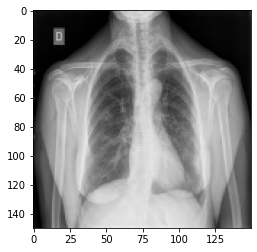

In [31]:
%matplotlib inline
uploaded = files.upload()
for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=64)

  if classes[0,0]!=0:
    print('covid')
  elif classes[0,1]!=0:
    print('normal')
  else:
    print('pneunomia')

In [32]:
model.save("model.h5")